<h1><font color="darkblue">An Elementary ("Toy") Agent-Based Model<br/> Showing the Impact of Social Distancing to Epidemic Spreading</font></h1>

by [Erika Fille Legara](https://erikalegara.site) (@eflegara) 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eflegara/Network-Science-Lectures/blob/master/notebooks/06_vaccination_strategies.ipynb)

---

### What's this about?
We have all probably read by now that one of the more effective ways of battling the spread of #COVID19 is through “social distancing” with the objective of minimizing the occurrence of contact between individuals.

Social distancing could be through school or work closure, quarantining or self-quarantining, “self shielding”, cancelling mass gatherings, etc. It’s really just about keeping your distance from people/community. Check out this compelling article titled [Coronavirus: Why You Must Act Now by Tomas Pueyo](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca).

Is social distancing really effective? Yes. Here's a compelling evidence \[[source](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca)\] from a PNAS paper where death rates between two cities (Philadelphia and St. Louis) during the 1918 pandemic were compared. The reason why the incidents/cases/deaths in St. Louise (broken trendline) didn’t grow as much was due to social distancing. 

<img src="./figure/sd-empirical.png" width="75%">

[Vox](https://www.vox.com/2020/3/10/21171481/coronavirus-us-cases-quarantine-cancellation) has another version of a "similar" plot ([from CDC](https://stacks.cdc.gov/view/cdc/11425)). In the figure below, it shows what epidemiologists refer to as "flattening the curve" strategy. The strategy is to deploy social distancing measures so we do not overwhelm the capacity of hospitals and other resources. Social distancing essentially delays the spread of the virus in a social network.

<img src="./figure/flattening_the_curve_final.png" width="70%">

I personally wanted to see this trend or "impact" of social distancing for myself through in-silico experiments using a very elementary approach to epidemic modeling (how viruses spread across social networks). Thus, here we build and run an epidemic model with the most elementary of assumptions (SI model), which is unrealistic. 

<div class="alert alert-block alert-info">
SI models are unrealistic. They assume that individuals do not recover from the disease; thus, everyone in the population will become infected eventually. However, this notebook is only used to illustrate a concept; and nothing more. 
</div>

And here are some of the results. Indeed, even with an elementary epidemic model (SI), we were able to illustrate the impact of social distancing. The general trends/profiles obtained are comparable to the empirical evidence presented in the PNAS paper.

<img src="./figure/sd-model-results.png" width="80%">

<div class="alert alert-block alert-info">
    <b>Note:</b> The specific percentages in the simulation results are dependent on the network structure assumptions used in the model. In this *toy model*, we have arbitrarily set the number of individuals to $N=2000$. We are also using a small-world network. The infection rate ( $\beta$ ) is also set arbitrarily in this exercise. Nonetheless, the main insight still holds since we are comparing trends and mechanisms across similar networks, albeit using toy models.
</div>


Remember,
> "All models are wrong, but some are useful". - George Box

What does this mean? The relevance of the model depends on what you want to see or unravel from it.

In [1]:
# Setup cell - Install required packages
import sys

# Check if we're in Google Colab
if 'google.colab' in sys.modules:
    print("Running in Google Colab - installing required packages...")
    !pip install lmfit
    print("✓ lmfit installed")
else:
    print("Running locally")
    # Check if lmfit is available
    try:
        import lmfit
        print("✓ lmfit already available")
    except ImportError:
        print("⚠️  lmfit not found. Please install it:")
        print("   conda install -c conda-forge lmfit") 
        print("   OR")
        print("   pip install lmfit")

Running locally
✓ lmfit already available


## The SI Model

The SI (susceptible-infected) model is probably the most basic model for the spread of epidemics. Here, all citizens of a population do not have any form of immunity; i.e., they are all susceptible. In addition, in this model, once individuals (or agents) get infected, they do not recover; worse, they can aggravate the incidence and prevalance of infection. 

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random 
import collections

from numpy import exp, pi, sqrt

from lmfit import Model
from scipy.integrate import quad
import scipy.special as special
from scipy.optimize import root

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Features of the Model

In the next few cells, we initialize the model with some global variables and functions. Below, we describe some of these features/parameters.

1. `G` defines the social network we are using in the simulation. I arbitrarily chose a small-world network: i.e., the network has short path length and high-clustering coefficient. The social network is important as it defines the social connections of the population. 
2. `N` is the total population. We set this to `N=2000`.
3. `tot_days` is the total number of "days" the model covers.
4. `beta` is the infection rate, which is the likelihood that a neighbor of an infected individual gets infected as well.
5. `alpha` is the rate of removal (only for SIR model).

In [3]:
def InitializeGlobalVariables():
    global N, beta, alpha, tot_days, G
    beta = 0.1
    alpha = 0.4
    N = 2000 
    tot_days = 30
    G = nx.Graph()
    G = nx.watts_strogatz_graph(N, 12, .6, seed=222)

In [4]:
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

### Agent-Based Model (ABM)

The SI model will be implemented through ABM wherein individuals are called "agents" and where an agent is a person in the population who has her own attributes. In the figure below, we highlight agents 7, 8, and 9 and highlight the attribute of Agent 8. Note that all agents will have the same attributes with, of course, different values.

<img src="../figure/abm-schematic.png" width="100%">

In the `class` defined below, the different attributes of the agents are as follows:

1. `agentid` - we need to track the agents in the simulation.
2. `status` - $S$ for "susceptible", $I$ for "infected", and $R$ for "recovered"
3. `social_distancing` - whether or not an agent practices/exhibits "social distancing"
4. `neighbors` - this feature lists all of the connections/friends of the individual agent

The other functions in the class are either modifiers or accessors.

In [5]:
class Agent:
    def __init__ (self, a_id, day, sd):
        self.agentid = a_id
        self.status = 'S'
        self.social_distancing = sd # yes
        self.neighbors = list(G.neighbors(a_id))
    # modifiers
    def updateStatus(self):
        if self.status == 'S':
            self.status = 'I'
            return 
        elif self.status == 'I':
            self.status = 'R'
            return
        else:
            return self.status
    def setStatus(self, s):
        self.status = s
    # accessors
    def getStatus(self):
        return self.status
    def getNeighbors(self):
        return self.neighbors
    def isSusceptible(self):
        if self.status == 'S':
            return True
        else:
            False
    def isSocialDistancing(self):
        if self.social_distancing == 1:
            return True
        else:
            return False
    def isInfected(self):
        if self.status == 'I':
            return True
        else:
            return False

#### Creating the Agents
The function below creates our agents. In the function, we use the `sd_pop_rate` variable as an argument. Again, what this does is determine whether an agent we're creating will participate in social distancing or not.

In [6]:
def CreateAgents(sd_pop_rate):
    agents = []
    for ID in range(N):
        # check if agent practices social distancing
        if random.random() < sd_pop_rate:
            sd = 1
        else:
            sd = 0
        agents.append(Agent(ID, 0, sd)) 
    return agents

# Set all nodes to susceptible; that is, not infected
def ResetStatus():
    for ID in range(N):
        agents[ID].setStatus('S')

#### Running the Simulation

In [7]:
def RunSimulation(sd, infect_node):
    list_of_infected = []
    list_of_recovered = []
    increase_per_day = {}
    days_status = {}

    list_of_infected.append(infect_node)
    
    for t in range(tot_days):
        new_infected = 0
        for a in list_of_infected:
            neighbors = agents[a].getNeighbors()
            for n in neighbors:
                if n not in list_of_infected:
                    if agents[n].isSocialDistancing(): ## If true
                        ## sd is the chance of not getting infected due to social distancing
                        ## this is the effectivity of social distancing
                        if (random.random() > sd) and (random.random() < beta):
                            agents[n].updateStatus()
                            list_of_infected.append(n)
                            new_infected = new_infected + 1
                    else:
                        if random.random() < beta:
                            agents[n].updateStatus()
                            list_of_infected.append(n)
                            new_infected = new_infected + 1
                
#                 ### See if infected recovers
#                 ### For use with SIR-model
#                 else:
#                     if random.random() < alpha:
#                         agents[n].updateStatus()
#                         list_of_recovered.append(n)
#                         list_of_infected.remove(n)
                    
        increase_per_day[t] = new_infected
        days_status[t] = len(list_of_infected)
        
    return days_status, increase_per_day

## Comparing Trends Across % Population Practicing SD
Below is the maiin body of the simulation. Note that we are dealing with a stochastic process; thus, it is expected different outcomes for every run. In addition, $t=0$ represents the onset of an outbreak.

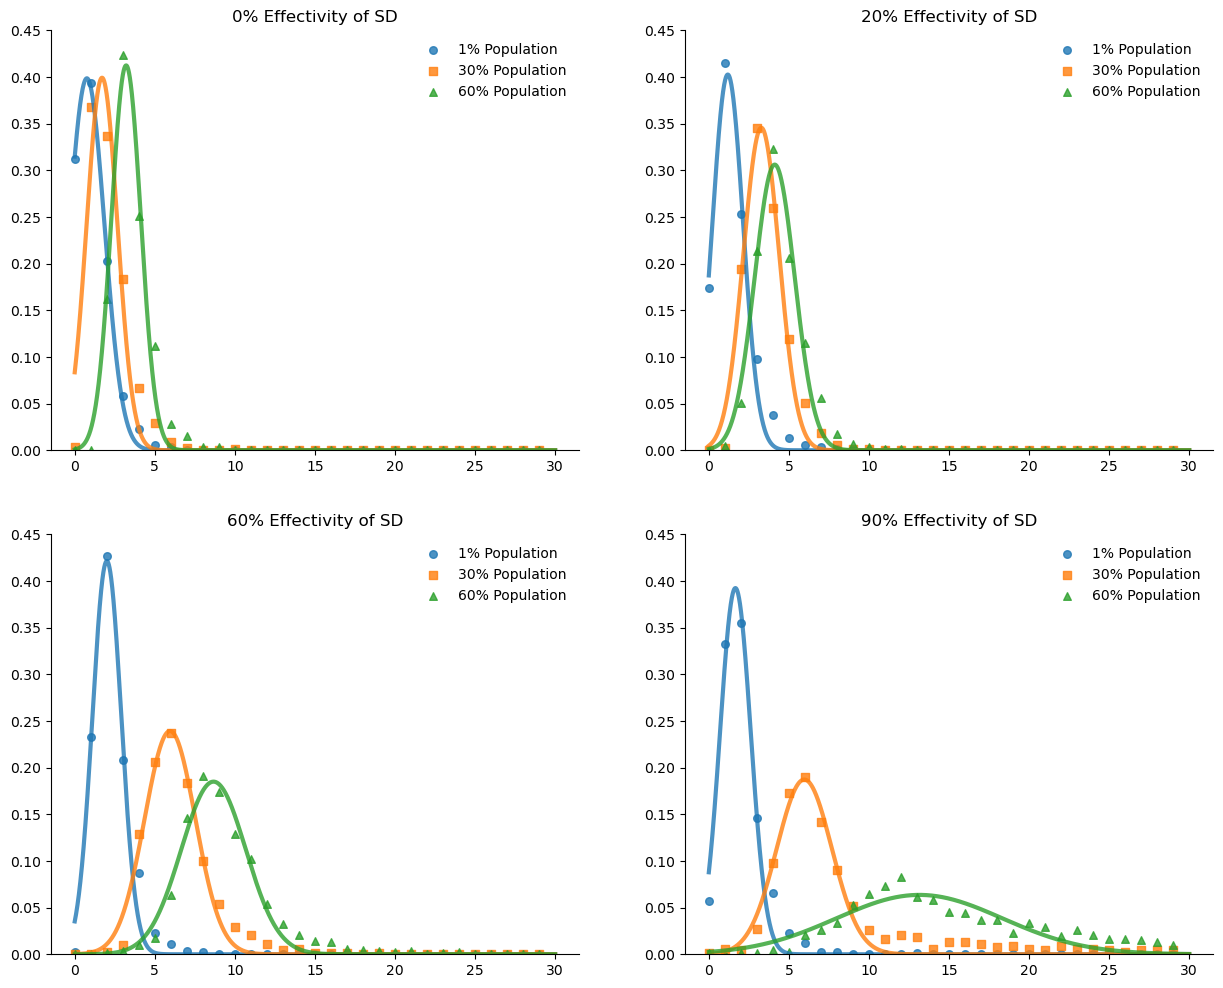

In [8]:
if __name__ == "__main__":
    tableau10 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD',
             '#8C564B', '#CFECF9', '#7F7F7F', '#BCBD22', '#17BECF']
    gmodel = Model(gaussian)
    labels = ['1% Population', "30% Population", "60% Population"]
    markers = ['o','s','^', 'v']
    par_trends = collections.defaultdict(dict)
    
    InitializeGlobalVariables()
    
    plt.figure(figsize=(15,12))
    plot_index = 1
    
    # sd would be social distancing effectivity
    sd_effectivities = [0,.2,.6,.9]
    
    # % population practising social distancing
    sd_pop_rates = [.01,.3,.6] 
    
    for sd in sd_effectivities: 
        plt.subplot(2,2,plot_index)
        i = 0
        for sd_rate in sd_pop_rates:
            agents = CreateAgents(sd_rate)
            
            # Randomly choose one spreader
            infect_node = random.randint(0, N+1)
            agents[infect_node].updateStatus()
#             print('Randomly infecting a person: Person ' + 
#                   str(infect_node) + ' is now infected.')
            
            day_status, new_infected = RunSimulation(sd, infect_node)
                     
            x = list(range(tot_days))
            y = list(new_infected.values())
            y = [yy/N for yy in y]
            result = gmodel.fit(y, x = x, amp = 10, cen = 5, wid=50)
            [amp, cen, wid] = result.best_values.values()
            
            plt.scatter(x, y,
                        color=tableau10[i], label = labels[i], 
                        marker=markers[i], alpha = .8, s=30)
            
            x_fit = np.arange(0,30,.001)
            y_fit = gaussian(x_fit, amp, cen, wid)
            plt.plot(x_fit, y_fit, '-', lw=3, color = tableau10[i], alpha = 0.8)
            
            par_trends[sd][sd_rate] = y
            
            i = i+1 
            
            plt.title(str(int(sd*100)) + "% Effectivity of SD")
            plt.legend(frameon=False)
            plt.ylim(0,.45)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
        
        plot_index = plot_index+1
    plt.show()

## What does this mean?
Focusing on the values of the last set of parameters (with 90% SD effectivity), we compare the incidence of infection for different SD population rates: 1%, 30%, and 60%. Again, SD population rate is the $%$ population who adopt social distancing measures.

In [9]:
y1 = par_trends[.9][.01]
y2 = par_trends[.9][.3]
y3 = par_trends[.9][.6]

y1_fit = gmodel.fit(y1, x = x, amp = 10, cen = 5, wid=50).best_fit
y2_fit = gmodel.fit(y2, x = x, amp = 10, cen = 5, wid=50).best_fit
y3_fit = gmodel.fit(y3, x = x, amp = 10, cen = 5, wid=50).best_fit

[amp1, cen1, wid1] = gmodel.fit(y1, x = x, amp = 10, cen = 5, wid=50).best_values.values()
[amp2, cen2, wid2] = gmodel.fit(y2, x = x, amp = 10, cen = 5, wid=50).best_values.values()
[amp3, cen3, wid3] = gmodel.fit(y3, x = x, amp = 10, cen = 5, wid=50).best_values.values()

x_gran = np.arange(0,30,.0001)
y1_gran = gaussian(x_gran, amp1, cen1, wid1)
y2_gran = gaussian(x_gran, amp3, cen3, wid3)

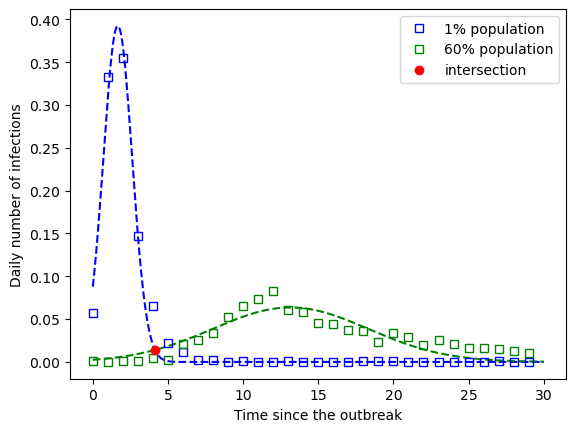

In [10]:
plt.plot(x_gran, y1_gran,'b--')
plt.plot(x_gran, y2_gran,'g--')
plt.plot(x, y1, 'bs', mfc='none', label='1% population')
plt.plot(x, y3, 'gs', mfc='none', label='60% population')
idx = np.argwhere(np.diff(np.sign(y1_gran - y2_gran))).flatten()
plt.plot(x_gran[idx], np.array(y1_gran)[idx], 'ro', label='intersection')
plt.xlabel('Time since the outbreak')
plt.ylabel('Daily number of infections')
plt.legend()
plt.show()

#### Finding Root
Here, we find the root of where the two curves intersect.

In [11]:
def diff_gaussian(x, amp1, cen1, wid1, amp3, cen3, wid3):
    return (gaussian (x,amp1, cen1, wid1) - gaussian(x,amp3, cen3, wid3))

In [12]:
sol = root(diff_gaussian, 5, args = (amp1, cen1, wid1, amp3, cen3, wid3), method='hybr')
intersection = int(sol.x)
print(intersection)

4


The intersection is the $n$th day when the two curves intersect. 

In [13]:
np.sum(y1[:int(intersection)])*100

89.1

In [14]:
np.sum(y3[int(intersection):])*100

86.55000000000001

#### Thoughts
What the results suggest is that it takes only about a few days **after an outbreak** for the number of incidents to reach about 70-90% of the model population (*we used only N=2000 people in this simulation*) **when social distancing is not practiced**. On the other hand, when SD is practiced, the spread is delayed giving more time for an administrative region to deal with the disease. For example, here, we see that it takes a little over 20 days for almost the same number of incidents (70-90%) to happen (*again, for N=2000 people*). 

This is a compelling result and argument that social distancing works, especially in this time of COVID-19. With social distancing, we help lessen the deluge of infected patients brought to or admitted to our hospitals. With this deliberate delay of the spread of infection, our hospital resources (equipment and health workers) are properly managed and are not overcapacitated.

---

Disclaimer: The network model and all other parameters do not reflect actual/empirical numbers. The main idea of this notebook is to illustrate a concept using the most elementary model available.

*Tip: Try to run multiple instances of this simulation to get the average incidents for each time interval for each mechanism. In this notebook, we are only running the experiment one time.*

## Exercises
1. Try to modify the model to include recovery of infected individuals (SIR model).
2. What if there's vaccination, how will it impact the spread?
3. How will the dynamics change when you use a different social network model (e.g. scale-free network, empirical networks)?
4. All individuals in this in-silico experiment decide at the onset ($t=0$) whether or not they will participate in different social distancing measures. How will this model change if we impose different time thresholds or incident thresholds when individuals realize they must practice social distancing? Remember, each individual have different reaction times to onset of disasters/outbreaks.

## Supplementary: Let's view a sample network.
This is only for illustration, to show how the network somehow looks when $x$% of its population are practicing social distancing (orange nodes).

In [15]:
g = nx.karate_club_graph()
pos = nx.spring_layout(g)
plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

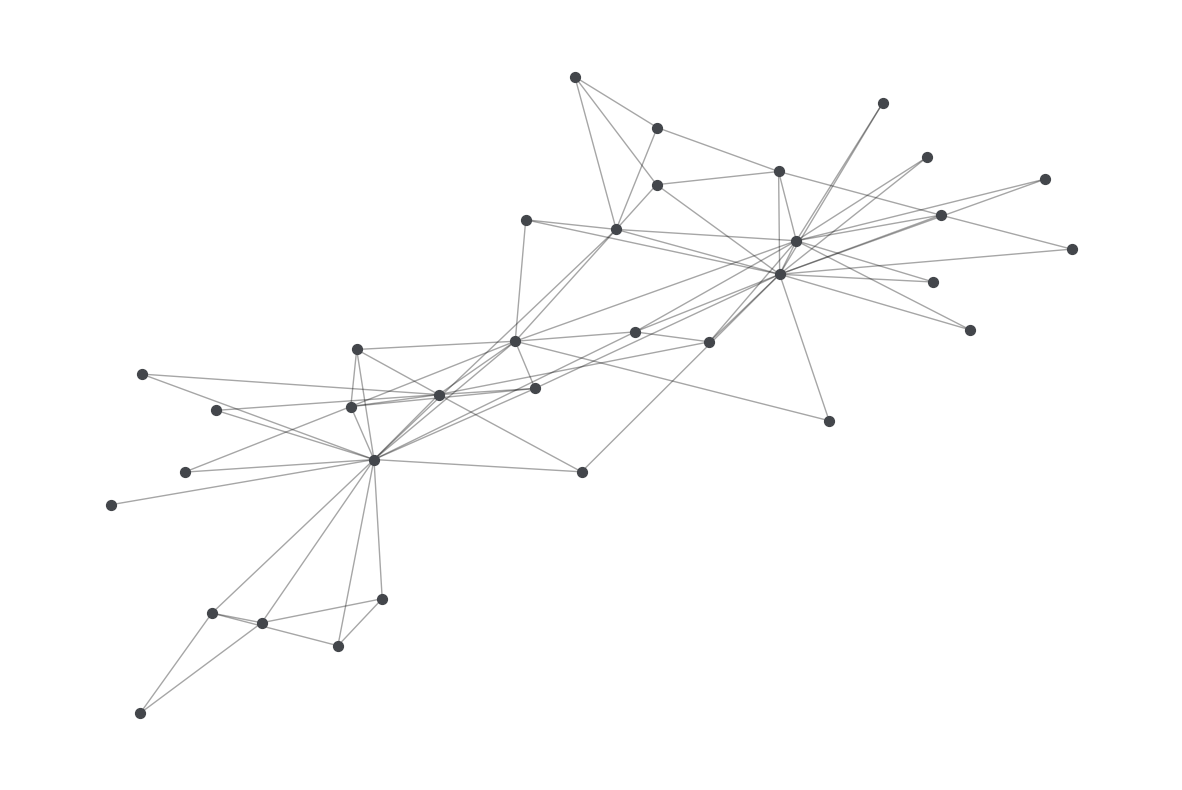

In [16]:
nx.draw_networkx_nodes(g, pos, node_size=50, node_color='#43464b')
nx.draw_networkx_edges(g, pos, alpha = 0.3500)
plt.axis('off')
plt.show()

### 10% of Population Practice "Social Distancing" Measures

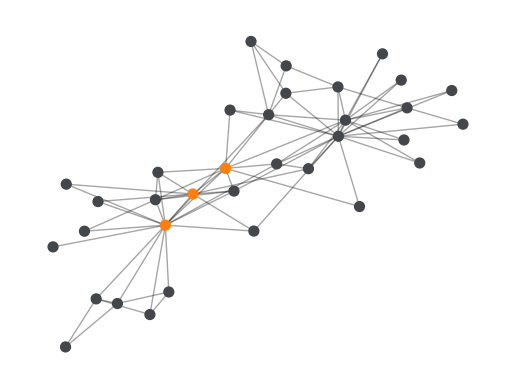

In [17]:
nx.draw_networkx_nodes(g, pos, node_size=50, node_color=[tableau10[1]]*3+ ['#43464b']*31)
nx.draw_networkx_edges(g, pos, alpha = 0.3500)
plt.axis('off')
plt.show()

### 30% of Population Practice "Social Distancing" Measures

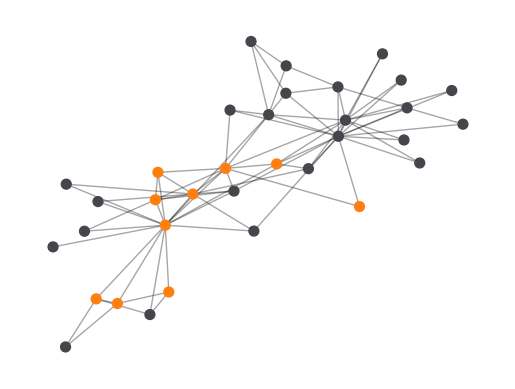

In [18]:
nx.draw_networkx_nodes(g, pos, node_size=50, node_color=[tableau10[1]]*10+['#43464b']*24)
nx.draw_networkx_edges(g, pos, alpha = 0.3500)
plt.axis('off')
plt.show()

### 40% of Population Practice "Social Distancing" Measures

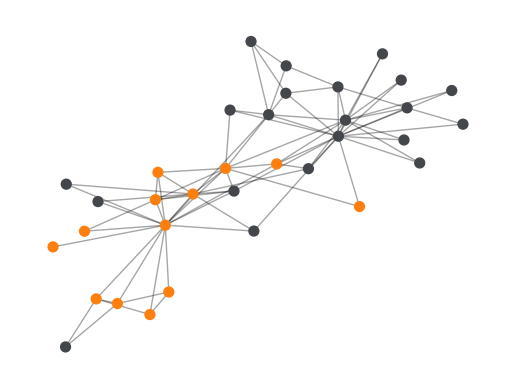

In [19]:
nx.draw_networkx_nodes(g, pos, node_size=50, node_color=[tableau10[1]]*13+['#43464b']*21)
nx.draw_networkx_edges(g, pos, alpha = 0.3500)
plt.axis('off')
plt.show()

### 60% of Population Practice "Social Distancing" Measures

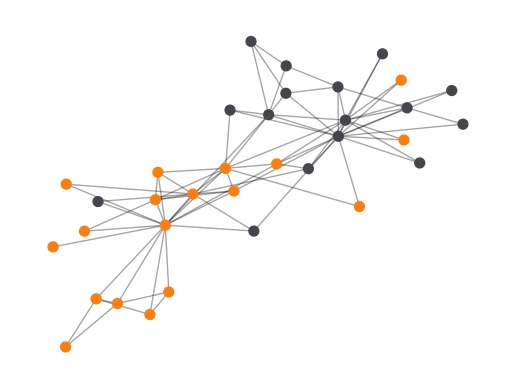

In [20]:
nx.draw_networkx_nodes(g, pos, node_size=50, node_color=[tableau10[1]]*18+['#43464b']*16)
nx.draw_networkx_edges(g, pos, alpha = 0.3500)
plt.axis('off')
plt.show()

### 80% of Population are "Social Distancing"

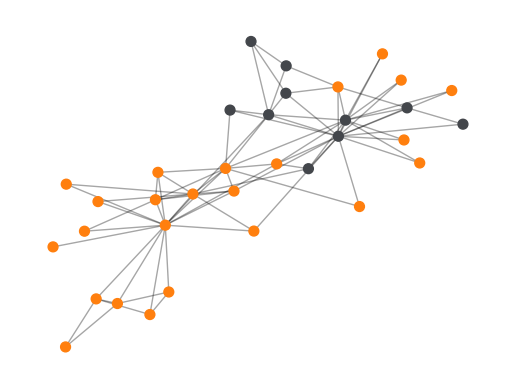

In [21]:
nx.draw_networkx_nodes(g, pos, node_size=50, node_color=[tableau10[1]]*24+['#43464b']*10);
nx.draw_networkx_edges(g, pos, alpha = 0.3500)
plt.axis('off')
plt.show()

---

Citation: Legara, E.F. (2020) An Elementary Agent-Based Model Showing the Impact of Social Distancing to Epidemic Spreading in _Network Science Lectures_, Available from: `https://github.com/eflegara/Network-Science-Lectures` \[Accessed: DD Month YYYY\]


---
The MIT License (MIT)

Copyright (c) 2020-2025 Erika Fille Legara  

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.